## MLOPs exercises

 
## 1. Task 1 Create a function that preprocess new ames data in the same way as the original ames data was preprocessed in step 5 in the `MLOps.ipynb` notebook.

In [1]:
#import Libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
#Preprocess Function
def preprocess_input(input):
    """
        Preprocess the Ames Housing Dataset and creates dummy variables for the Bldg Type and Neighborhood columns
    """
    df = input[["Lot Area", "Overall Cond", "Year Built", "Gr Liv Area", "TotRms AbvGrd", "Mo Sold", "Yr Sold", "Bldg Type", "Neighborhood", "SalePrice"]]
    #Create Dummy Variables for the Building Type
    df = df.join(pd.get_dummies(df["Bldg Type"], drop_first=True, dtype=int, prefix="BType:"))
    
    #Create Dummy Variables for the Neighborhood
    df = df.join(pd.get_dummies(df["Neighborhood"], drop_first=True, dtype=int, prefix="Nbh:"))

    #Drop the original columns
    df = df.drop(columns=["Bldg Type", "Neighborhood"])

    return df

In [3]:
#Load the initial ames data
ames = pd.read_csv("Datasets/AmesHousing.csv")


In [4]:
#Preprocess the initial Data
ames_i = preprocess_input(ames)

## 2.Create a function that takes as input a new ames dataset and a model. The function should pre-process the new data and evaluate the model on that new data using mean absolute error.

In [5]:
#Import Libraries
from sklearn import linear_model
from sklearn.model_selection import train_test_split 
from sklearn.metrics import  mean_absolute_error, mean_squared_error

In [6]:
#Function to evaluate the date
def evaluate_new_data(input_data, model):
    """
        Evaluate the model on new data

        Returns:
            mae
    """

    
    df = preprocess_input(input_data)

    #Separate the features and the target
    X_ames = df.drop(columns=["SalePrice"])
    y_ames = df["SalePrice"]

    #Train-test split the data
    X_train, X_test, y_train, y_test = train_test_split(X_ames, y_ames, test_size=0.2, random_state=42)

    #Train-Validate training data
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    mae = mean_absolute_error(y_val, y_pred)

    return mae

## 3.Test the function from 2. on the "NewAmesData1.csv" dataset and the best model from the `MLOps.ipynb` notebook.

In [7]:
#Load new data
new_data_1 = pd.read_csv("Datasets/NewAmesData1.csv")

In [8]:
#Import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor

In [9]:
#Evaluate the model
model = GradientBoostingRegressor()
mae_GradientBoosting = evaluate_new_data(new_data_1, model)
print(f"MAE for Gradient Boosting on NewAmesData1: {mae_GradientBoosting}")

MAE for Gradient Boosting on NewAmesData1: 24511.93496281209


## 4. Test the function from 2. on the "NewAmesData2.csv" dataset and the best model from the `MLOps.ipynb` notebook. Do you see any drift?

In [10]:
#Load new data
new_data_2 = pd.read_csv("Datasets/NewAmesData2.csv")

In [11]:
#Evaluate the model
model = GradientBoostingRegressor()
mae_GradientBoosting = evaluate_new_data(new_data_2, model)
print(f"MAE for Gradient Boosting on NewAmesData2: {mae_GradientBoosting}")

MAE for Gradient Boosting on NewAmesData2: 54293.94035214512


In [15]:
ames_2 = preprocess_input(new_data_2)

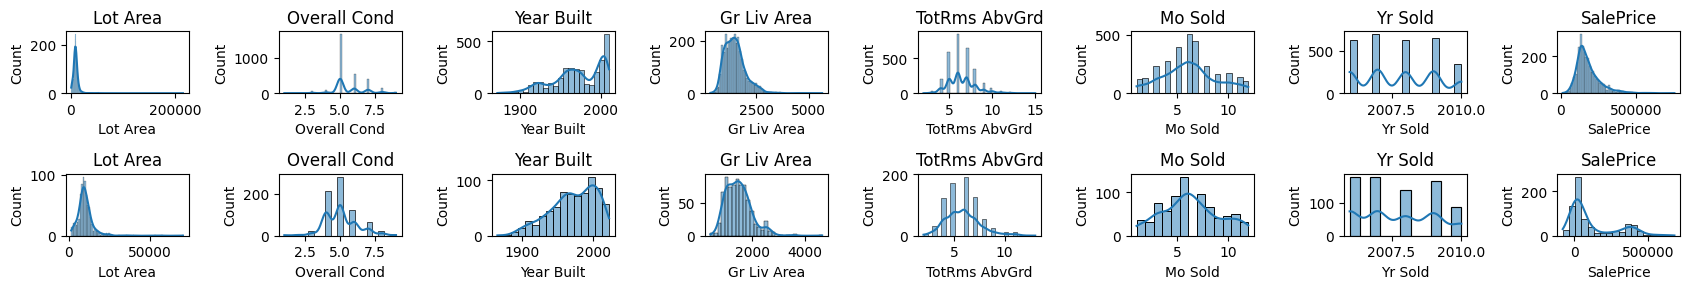

In [16]:
# Create subplots with a 2x7 grid
fig, axes = plt.subplots(2, 8, figsize=(17, 3))  # Adjusted figsize

# Plot each column as a histogram
for i, column in enumerate(ames_i.columns[:8]):
    sns.histplot(ames_i[column], ax=axes[0,i], kde=True)
    axes[0,i].set_title(column)
for i, column in enumerate(ames_2.columns[:8]):
    sns.histplot(ames_2[column], ax=axes[1,i], kde=True)
    axes[1,i].set_title(column)

plt.tight_layout()
plt.show()

In [17]:
#Kolmogorov-Smirnov
from scipy.stats import ks_2samp

for column in ames_2.columns:
    stat, p_value = ks_2samp(ames_i[column], ames_2[column])
    if p_value < 0.05:
        print(f"Feature {column} has changed (p={p_value:.3f})")

Feature Overall Cond has changed (p=0.000)
Feature Year Built has changed (p=0.000)
Feature TotRms AbvGrd has changed (p=0.000)
Feature SalePrice has changed (p=0.000)


For starters there is Concept drift as we see that the model if perfroming worse on this new data. Also there label drift as well as data drift since the distributions vary.

## 5. Do you see a data drift in "NewAmesData2.csv"? If so, for which variables?

From a first glimpse we see that our model's MAE has doubled on the new dataset which indicates Concept drifting. The relationship between the features and the target has changed.

Let explore which variables cause the a change in the underlying pattern and the model is seeing different type of input than what is was trained on.
We are examining in two ways.
1. PLotting the distributions of fetures for the two datasets
2. Using Kolmogorov-Smirnov to compare the feature distributions.

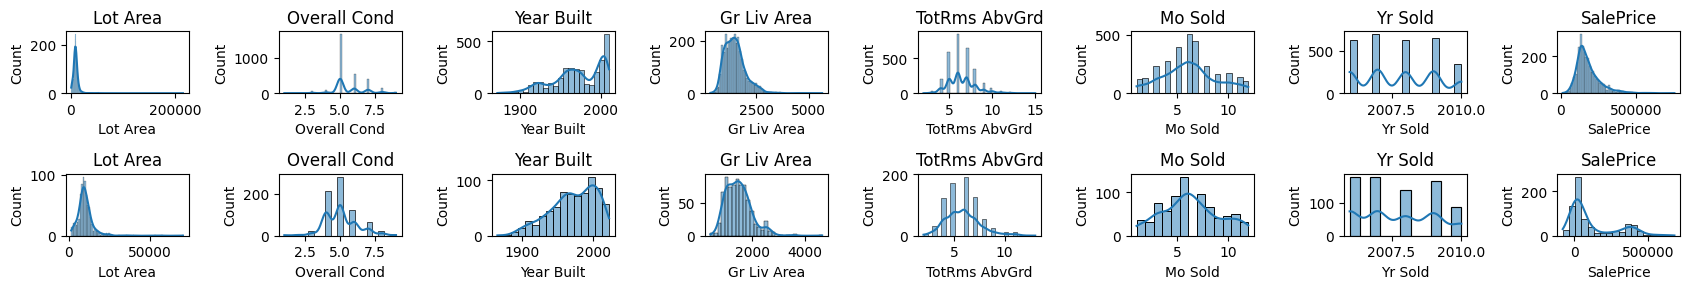

In [19]:
# Create subplots with a 2x7 grid
fig, axes = plt.subplots(2, 8, figsize=(17, 3))  # Adjusted figsize

# Plot each column as a histogram
for i, column in enumerate(ames_i.columns[:8]):
    sns.histplot(ames_i[column], ax=axes[0,i], kde=True)
    axes[0,i].set_title(column)
for i, column in enumerate(ames_2.columns[:8]):
    sns.histplot(ames_2[column], ax=axes[1,i], kde=True)
    axes[1,i].set_title(column)

plt.tight_layout()
plt.show()

From the plot we can cleary see that the distribution of SalePrice has change, which indicates Label Drift. Meaning our model needs to be retrained.
But lets verify it with Kolmogorov-Smirnov.

In [22]:
#Kolmogorov-Smirnov
from scipy.stats import ks_2samp

for column in ames_2.columns:
    stat, p_value = ks_2samp(ames_2[column], ames_i[column])
    if p_value < 0.05:
        print(f"Feature {column} has changed (p={p_value:.3f})")

Feature Overall Cond has changed (p=0.000)
Feature Year Built has changed (p=0.000)
Feature TotRms AbvGrd has changed (p=0.000)
Feature SalePrice has changed (p=0.000)


We see that there is datadrift in the above features.

## 6. Do you see a data drift in "NewAmesData4.csv"? If so, for which variables?

In [23]:
#Load new data
new_data_4 = pd.read_csv("Datasets/NewAmesData4.csv")

In [24]:
#Evaluate the model
model = GradientBoostingRegressor()
mae_GradientBoosting = evaluate_new_data(new_data_4, model)
print(f"MAE for Gradient Boosting on NewAmesData2: {mae_GradientBoosting}")

MAE for Gradient Boosting on NewAmesData2: 25908.516663306


In [25]:
ames_4 = preprocess_input(new_data_4)

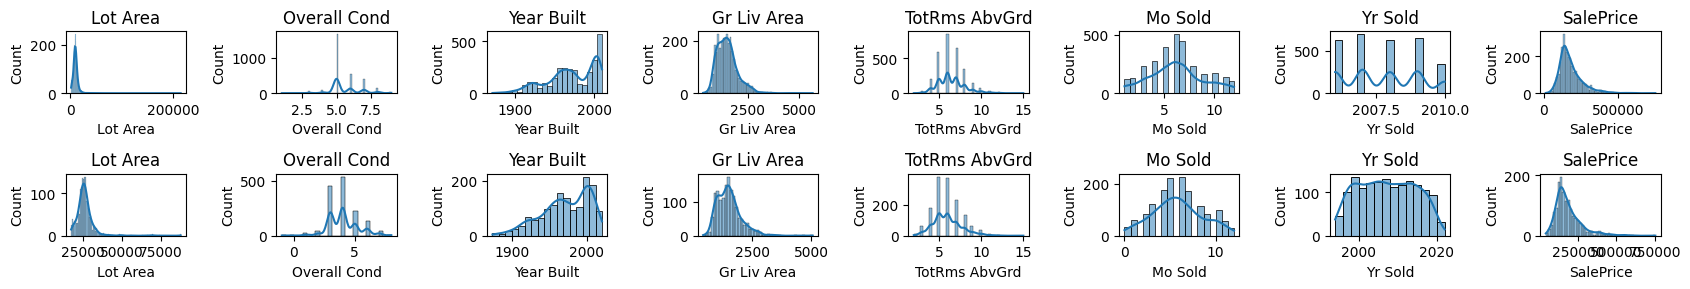

In [26]:
#Plot the two dataset
# Create subplots with a 2x7 grid
fig, axes = plt.subplots(2, 8, figsize=(17, 3))  

# Plot each column as a histogram
for i, column in enumerate(ames_i.columns[:8]):
    sns.histplot(ames_i[column], ax=axes[0,i], kde=True)
    axes[0,i].set_title(column)
for i, column in enumerate(ames_4.columns[:8]):
    sns.histplot(ames_4[column], ax=axes[1,i], kde=True)
    axes[1,i].set_title(column)

plt.tight_layout()
plt.show()

In [28]:
#Kolmogorov-Smirnov
for column in ames_4.columns:
    stat, p_value = ks_2samp(ames_4[column], ames_i[column])
    if p_value < 0.05:
        print(f"Feature {column} has changed (p={p_value:.3f})")

Feature Lot Area has changed (p=0.000)
Feature Overall Cond has changed (p=0.000)
Feature Year Built has changed (p=0.000)
Feature TotRms AbvGrd has changed (p=0.000)
Feature Mo Sold has changed (p=0.000)
Feature Yr Sold has changed (p=0.000)


There is data drift in the above features.